In [1]:
import torch
import time
import numpy as np
import matplotlib.pyplot as plt
from kernel import fm, fm_compile, fm_kernel
device = torch.device("cuda:0")

/home/hanhui/miniconda3/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# write a benchmark for the kernel
cpu_time_fm = []
cpu_time_fm_compile = []
cpu_time_fm_kernel = []


def benchmark(func, p, iters=100):
    fwd_time = []
    bwd_time = []
    x = torch.randn((128, 2**p, 128), device=device, requires_grad=True)
    for _ in range(3):  # warm up
        func(x)
    for _ in range(iters):
        torch.cuda.synchronize(device)
        t0 = time.time()
        y = func(x)
        torch.cuda.synchronize(device)
        t1 = time.time()
        y.backward(torch.ones_like(y))
        torch.cuda.synchronize(device)
        t2 = time.time()
        fwd_time.append(t1 - t0)
        bwd_time.append(t2 - t1)
    return [fwd_time, bwd_time]
    

pows = list(range(3, 12))
for p in pows:
    cpu_time_fm_ = []
    cpu_time_fm_compile_ = []
    cpu_time_fm_kernel_ = []

    cpu_time_fm.append(benchmark(fm, p))
    cpu_time_fm_compile.append(benchmark(fm_compile, p))
    cpu_time_fm_kernel.append(benchmark(fm_kernel, p))

cpu_time_fm = np.array(cpu_time_fm)
cpu_time_fm_compile = np.array(cpu_time_fm_compile)
cpu_time_fm_kernel = np.array(cpu_time_fm_kernel)


In [3]:
def plot_fig(cpu_time_fm, cpu_time_fm_compile, cpu_time_fm_kernel, title='Benchmark'):
    ax = plt.subplot()
    cpu_time_fm_mean = np.mean(cpu_time_fm, axis=1)
    cpu_time_fm_std = np.std(cpu_time_fm, axis=1)
    cpu_time_fm_compile_mean = np.mean(cpu_time_fm_compile, axis=1)
    cpu_time_fm_compile_std = np.std(cpu_time_fm_compile, axis=1)
    cpu_time_fm_kernel_mean = np.mean(cpu_time_fm_kernel, axis=1)
    cpu_time_fm_kernel_std = np.std(cpu_time_fm_kernel, axis=1)

    ax.plot(pows, cpu_time_fm_mean, label='fm')
    ax.fill_between(pows, cpu_time_fm_mean - cpu_time_fm_std, cpu_time_fm_mean + cpu_time_fm_std, alpha=0.2)
    ax.plot(pows, cpu_time_fm_compile_mean, label='fm_compile')
    ax.fill_between(pows, cpu_time_fm_compile_mean - cpu_time_fm_compile_std, cpu_time_fm_compile_mean + cpu_time_fm_compile_std, alpha=0.2)
    ax.plot(pows, cpu_time_fm_kernel_mean, label='fm_kernel')
    ax.fill_between(pows, cpu_time_fm_kernel_mean - cpu_time_fm_kernel_std, cpu_time_fm_kernel_mean + cpu_time_fm_kernel_std, alpha=0.2)
    ax.set_xlabel('power of 2')
    ax.set_ylabel('time (s)')
    ax.set_title(title)
    # ax.set_yscale('log')
    ax.legend()
    plt.show()

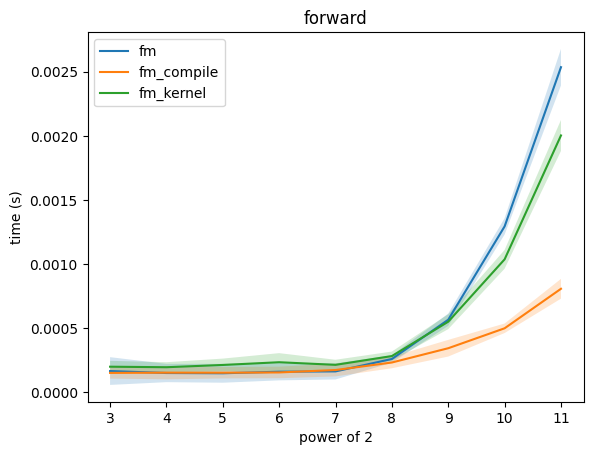

In [4]:
plot_fig(cpu_time_fm[:,0,:], cpu_time_fm_compile[:,0,:], cpu_time_fm_kernel[:,0,:], title='forward')

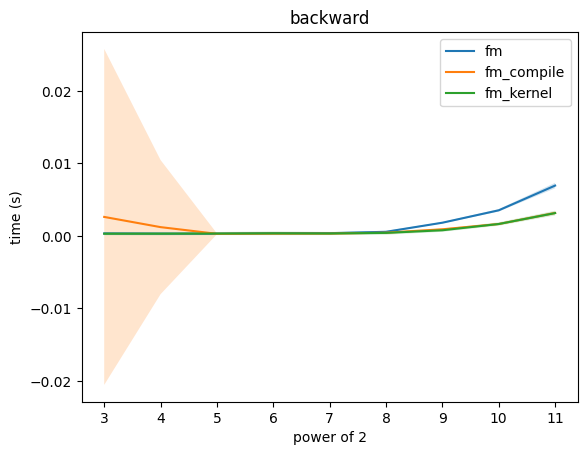

In [5]:
plot_fig(cpu_time_fm[:,1,:], cpu_time_fm_compile[:,1,:], cpu_time_fm_kernel[:,1,:], title='backward')

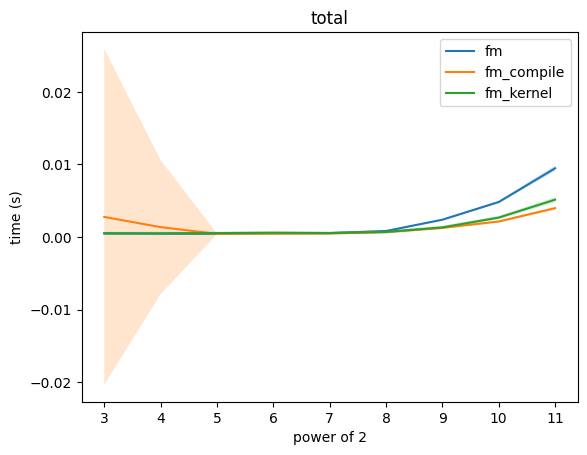

In [6]:
plot_fig(cpu_time_fm.sum(axis=1), cpu_time_fm_compile.sum(axis=1), cpu_time_fm_kernel.sum(axis=1), title='total')